In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

In [22]:
df = pd.read_csv('C:/Training/Academy/Statistics (Python)/Datasets/BUNDESBANK-BBK01_WT5511.csv')
timeseries = df[["Value"]].values.astype('float32')
timeseries.shape

(577, 1)

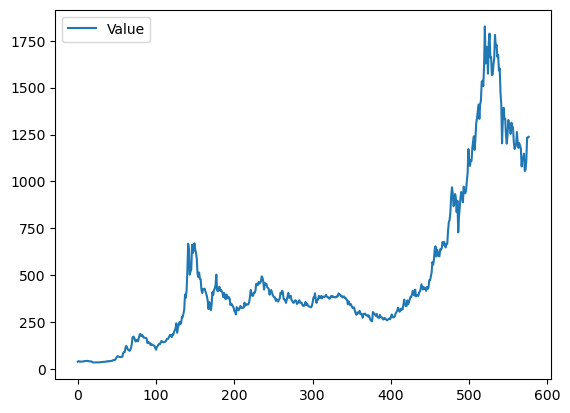

In [23]:
df.plot()
plt.show()

### train-test split for time series

In [24]:
len(timeseries)

577

In [32]:
train_size = int(len(timeseries) * 0.90)
test_size = len(timeseries) - train_size
org_train, org_test = timeseries[:train_size], timeseries[train_size:]

In [33]:
mm = MinMaxScaler()
train = mm.fit_transform(org_train)
test = mm.transform(org_test)

In [34]:
train.shape, test.shape

((519, 1), (58, 1))

In [35]:
type(train)

numpy.ndarray

In [36]:
dataset=train
lookback=4
X, y = [], []
for i in range(len(dataset)-lookback):
    feature = dataset[i:i+lookback]
    target = dataset[i+1:i+lookback+1]
    X.append(feature)
    y.append(target)

In [37]:
np.array(X)[:,:,0][0]

array([0.00274297, 0.00467371, 0.00397465, 0.00260982], dtype=float32)

In [39]:
np.array(y)[:,:,0][0]

array([0.00467371, 0.00397465, 0.00260982, 0.0032423 ], dtype=float32)

### Creating a Dataset

In [40]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [41]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([515, 4, 1]),
 torch.Size([515, 4, 1]),
 torch.Size([54, 4, 1]),
 torch.Size([54, 4, 1]))

### Model Definition

In [43]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Initialization and settings

In [44]:
torch.manual_seed(23)
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                         shuffle=True, batch_size=8)

### Training Loop

In [45]:
n_epochs = 2000
for epoch in range(0, n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch+1, train_rmse, test_rmse))



Epoch 1: train RMSE 0.1663, test RMSE 0.6303
Epoch 101: train RMSE 0.0178, test RMSE 0.0570
Epoch 201: train RMSE 0.0184, test RMSE 0.0555
Epoch 301: train RMSE 0.0176, test RMSE 0.0513
Epoch 401: train RMSE 0.0177, test RMSE 0.0636
Epoch 501: train RMSE 0.0181, test RMSE 0.0616
Epoch 601: train RMSE 0.0188, test RMSE 0.0755
Epoch 701: train RMSE 0.0176, test RMSE 0.0584
Epoch 801: train RMSE 0.0189, test RMSE 0.0535
Epoch 901: train RMSE 0.0172, test RMSE 0.0592
Epoch 1001: train RMSE 0.0178, test RMSE 0.0647
Epoch 1101: train RMSE 0.0172, test RMSE 0.0568
Epoch 1201: train RMSE 0.0177, test RMSE 0.0540
Epoch 1301: train RMSE 0.0172, test RMSE 0.0591
Epoch 1401: train RMSE 0.0175, test RMSE 0.0632
Epoch 1501: train RMSE 0.0178, test RMSE 0.0556
Epoch 1601: train RMSE 0.0174, test RMSE 0.0556
Epoch 1701: train RMSE 0.0179, test RMSE 0.0574
Epoch 1801: train RMSE 0.0172, test RMSE 0.0593
Epoch 1901: train RMSE 0.0173, test RMSE 0.0613


In [49]:
print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch+1, train_rmse, test_rmse))

Epoch 2000: train RMSE 0.0173, test RMSE 0.0613


In [52]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

In [54]:
train_plot = mm.inverse_transform( train_plot )
test_plot = mm.inverse_transform( test_plot )

### Time Series

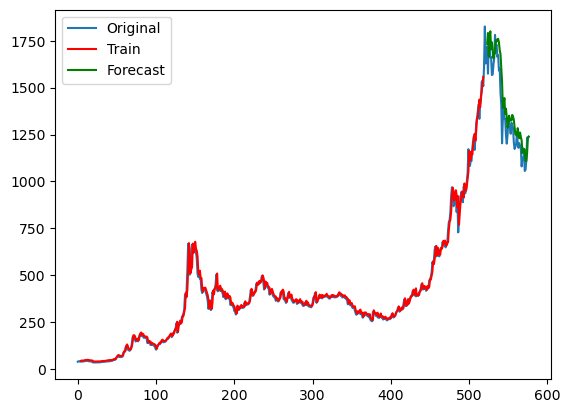

In [56]:
plt.plot(timeseries, label='Original')
plt.plot(train_plot, c='r' , label='Train')
plt.plot(test_plot, c='g', label='Forecast')
plt.legend(loc='best')
plt.show()